<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/image_classification/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will train a ConvNet to classify images from the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) database. The CIFAR-10 dataset consists of 60000, 32x32 colour images in 10 classes (airplane, automobile,bird, cat, deer,dog, frog, horse, ship, truck), with 6000 images per class. There are 50000 training images and 10000 test images.

The process will be broken down into the following steps:

    1. Load and visualize the dataset
    2. Define a neural network
    3. Define a Loss function and an optimizer
    4. Train the model on the training dataset
    5. Evaluate the performance of the trained model on the test dataset

In [1]:
# import required libraries
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available")
else:
  print("CUDA is available")

device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is available


### Load and visualize the dataset

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


# convert the data to a normalized torch.FloatTensor
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

# choose the training and test dataset
train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# obtain training indices for creating a validation dataset
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
# choose percentage of training data for validation
valid_size = 0.2
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20


# prepare train, test and valid data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, num_workers=num_workers)

# specify image classes in the dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


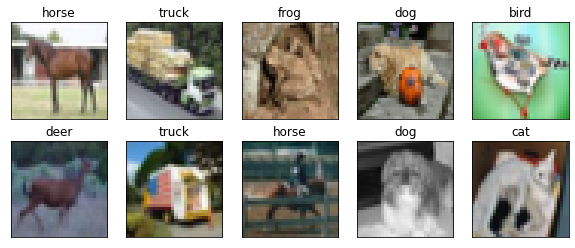

In [4]:
# visualize a batch of training data

def imshow(img):
  # unnormalize
  img = img / 2 + 0.5
  # convert from Tensor to image
  plt.imshow(np.transpose(img, (1,2,0)))

# obtain one batch on training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy() 

# plot the images in the batch along with the corresponding labels
fig = plt.figure(figsize=(10,4))
# display 10 images
for ind in np.arange(10):
  ax = fig.add_subplot(2, 10/2, ind+1, xticks=[], yticks=[])
  imshow(images[ind])
  ax.set_title(classes[labels[ind]])

### Define a neural network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # (sees 32x32x3 image tensor)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # (sees 16x16x16 tensor)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # (sees 8x8x32 tensor)

    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64*4*4, 500) 
    self.fc2 = nn.Linear(500, 10)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    # flatten image input
    x = x.view(-1, 64*4*4)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model = Net()
model.to(device)

print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Define a loss function and an optimizer

In [6]:
import torch.optim as optim

# specify a loss function
criterion = nn.CrossEntropyLoss() # categorical cross-entropy

# specify an optimizer
params = model.parameters()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Train the model on the training dataset

In [7]:
# number of epochs to train the model
num_epochs = 30

# track training and validation losses
train_loss, valid_loss = [], []

# initialize trackers for min validation loss
min_valid_loss = np.inf

for epoch in range(num_epochs):
  running_train_loss = 0.0
  running_valid_loss = 0.0

  #--------- train the model -----------
  # prepare model for training
  model.train()

  for batch_idx, data in enumerate(train_loader):
    inputs, targets = data
    inputs, targets = inputs.to(device), targets.to(device)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass
    outputs = model(inputs)
    # calculate the batch loss
    loss = criterion(outputs, targets)
    # backward loss
    loss.backward()
    # update parameters
    optimizer.step()
    # update training loss
    running_train_loss += loss.item() 

  # ---------- validate the model ----------
  # prepare model for evaluation
  model.eval()
  
  for batch_idx, data in enumerate(valid_loader):
    inputs, targets = data
    inputs, targets = inputs.to(device), targets.to(device)
    # forward pass
    outputs = model(inputs)
    # calculate the batch loss
    loss = criterion(outputs, targets)
    # update validation loss
    running_valid_loss += loss.item()

  
  # calculate average loss over an epoch
  running_train_loss = running_train_loss / len(train_loader)
  running_valid_loss = running_valid_loss / len(valid_loader)

  train_loss.append(running_train_loss)
  valid_loss.append(running_valid_loss)

  print("Epochs: {} \tTraining loss: {:.6f} \tValidation loss: {:.6f}".format(epoch+1, running_train_loss, running_valid_loss))

  # save model if validation loss has decreased
  if running_valid_loss <= min_valid_loss:
    print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ... ".format(
        min_valid_loss, running_valid_loss
    ))

    torch.save(model.state_dict(), 'model.pt')
    min_valid_loss = running_valid_loss

print("Finished training!")

Epochs: 1 	Training loss: 2.094368 	Validation loss: 1.866282
Validation loss decreased (inf --> 1.866282). Saving model ... 
Epochs: 2 	Training loss: 1.691505 	Validation loss: 1.490935
Validation loss decreased (1.866282 --> 1.490935). Saving model ... 
Epochs: 3 	Training loss: 1.479271 	Validation loss: 1.421428
Validation loss decreased (1.490935 --> 1.421428). Saving model ... 
Epochs: 4 	Training loss: 1.361975 	Validation loss: 1.264095
Validation loss decreased (1.421428 --> 1.264095). Saving model ... 
Epochs: 5 	Training loss: 1.265993 	Validation loss: 1.156509
Validation loss decreased (1.264095 --> 1.156509). Saving model ... 
Epochs: 6 	Training loss: 1.184036 	Validation loss: 1.085625
Validation loss decreased (1.156509 --> 1.085625). Saving model ... 
Epochs: 7 	Training loss: 1.115672 	Validation loss: 1.070992
Validation loss decreased (1.085625 --> 1.070992). Saving model ... 
Epochs: 8 	Training loss: 1.047793 	Validation loss: 0.968328
Validation loss decreased 

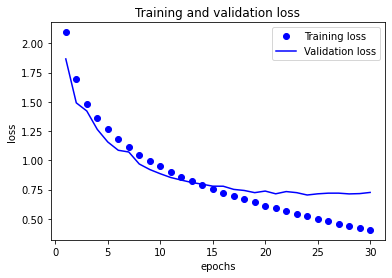

In [12]:
# plot trainining and validation loss for each epoch
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_loss, 'bo', label="Training loss")
plt.plot(epochs, valid_loss, 'b', label="Validation loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.show()

### Evaluate the performance of the trained model on the test dataset

In [13]:
# load the model with the lowest validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [14]:
# track test loss and accuracy
test_loss = 0.0
class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

# prepare model for evaluation
model.eval()

for batch_idx, data in enumerate(test_loader):
  inputs, targets = data
  inputs, targets = inputs.to(device), targets.to(device)
  
  # forward pass
  outputs = model(inputs)
  # calculate the batch loss
  loss = criterion(outputs, targets)
  # update test loss
  test_loss += loss.item()
  # convert output probabilities to predicted class
  _, predictions = torch.max(outputs, 1)
  # compare predictions to true labels
  correct_tensor = predictions.eq(targets.data.view_as(predictions))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each class
  for i in range(batch_size):
    label = targets.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader.dataset)
print("Test loss (overall): {:6f}\n".format(test_loss))

# print test accuracy for each classes
for i in range(len(classes)):
  if class_total[i] > 0:
    accuracy = (100 * class_correct[i]) / class_total[i]
    print(f'Test accuracy of {classes[i]:10s}: {accuracy:.1f} % ({np.sum(class_correct[i])}/{np.sum(class_total[i])})')

# overall test accuracy
test_acc = 100 * np.sum(class_correct) / np.sum(class_total)
print("\nTest accuracy (overall): %2d%% (%2d/%2d)" % ( 
      test_acc, np.sum(class_correct), np.sum(class_total)))


Test loss (overall): 0.036180

Test accuracy of airplane  : 84.8 % (848/1000)
Test accuracy of automobile: 86.3 % (863/1000)
Test accuracy of bird      : 56.4 % (564/1000)
Test accuracy of cat       : 48.0 % (480/1000)
Test accuracy of deer      : 76.8 % (768/1000)
Test accuracy of dog       : 68.6 % (686/1000)
Test accuracy of frog      : 86.6 % (866/1000)
Test accuracy of horse     : 79.9 % (799/1000)
Test accuracy of ship      : 83.7 % (837/1000)
Test accuracy of truck     : 80.6 % (806/1000)

Test accuracy (overall): 75% (7517/10000)


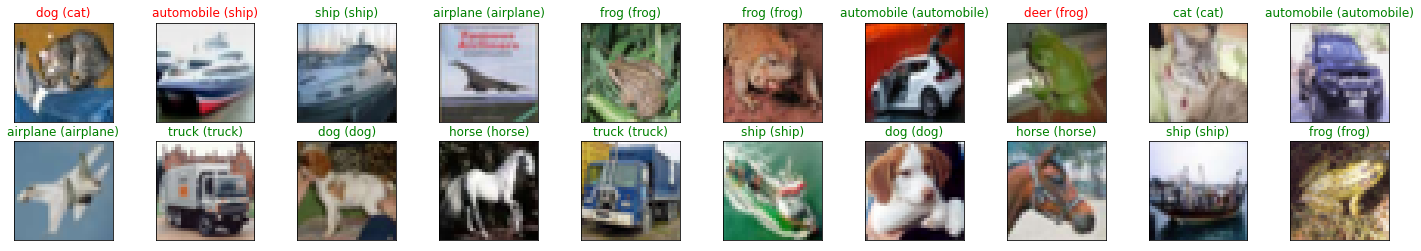

In [15]:
# visualize a sample test results

# get one batch of test images
dataiter = iter(test_loader)
inputs, targets = dataiter.next()
inputs.numpy()

inputs = inputs.to(device)

# get sample outputs
outputs = model(inputs)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(outputs, 1)
predictions = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images along with predicted class and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(inputs[idx] if not train_on_gpu else inputs[idx].cpu())
    ax.set_title("{} ({})".format(classes[predictions[idx]], classes[targets[idx]]),
                 color=("green" if predictions[idx]==targets[idx].item() else "red"))